This notebook aims to train and validate the softmax classifier as to compare its performance to that of an LSTM neural network for hate speech classification

# Import Libraries

In [152]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer

from utilities.data_preprocessors import read_preprocess, series_to_1D_array, construct_embedding_dict, construct_embedding_matrix, sentences_to_avgs
from utilities.data_visualizers import train_cross_results_v2, view_final_metrics
from models.softmax_regression import SoftmaxRegression

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [153]:
# 1 for religious and 0 for non religious
df = pd.read_csv('./data/hate-speech-data-cleaned.csv', index_col=0)
df = read_preprocess(df)

all_words = pd.Series(series_to_1D_array(df['comment']))
all_unique_words_counts = all_words.value_counts()
all_unique_words = all_words.unique()


In [154]:
df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

# Preprocess data

In [155]:
# rejoin the comment columns values of lists of words to sentences
df['comment'] = df['comment'].apply(lambda comment: " ".join(comment))
df

,comment,label
0,woman complain cleaning house man always take ...,1
1,boy dat coldtyga dwn bad cuffin dat hoe st place,0
2,dawg ever fuck bitch start cry confused shit,0
3,look like tranny,0
4,shit hear might true might faker bitch told ya,0
...,...,...
65775,from the midnight sun where the hot spring blow,1
65776,do not say am not your type,1
65777,and therefor never send to know for whom the b...,1
65778,and cannot stand anoth day,1


In [156]:
# at the same time one hot encode the y labels/classes
len_unique_labels = len(df['label'].unique())
Y_oh = one_hot(df['label'], len_unique_labels, dtype=tf.float64).numpy()
Y_oh

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

# Retrieving and assigning important variables for training classifier

In [157]:
sents = df['comment']

# get number of all unique words
num_words_3 = len(all_unique_words)

# instantiate Tokenizer on the total number of all unique words
tokenizer = Tokenizer(num_words=num_words_3, split=' ')

# call .fit_on_texts to create the word_index and index_word dicts
tokenizer.fit_on_texts(sents)

# save the tokenizer dictionaries for use later when loading GloVe embeddings
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word
print(len(word_to_index))
# print(word_to_index)

47916


In [158]:
# important variables

# includes oov words
emb_dict, emb_vec_len = construct_embedding_dict('./embeddings/glove.42B.300d.txt', word_to_index)
emb_matrix = construct_embedding_matrix(word_to_index, emb_dict, emb_vec_len)

100%|██████████| 47916/47916 [00:00<00:00, 243380.09it/s]


# Transform all sentences to word vectors

In [159]:
vect_sents = sentences_to_avgs(sents, emb_dict)

In [160]:
vect_sents

array([[ 0.00396263,  0.36776125, -0.04045763, ..., -0.06078575,
         0.09397175, -0.05599563],
       [ 0.29468613,  0.39194278,  0.03957122, ..., -0.03101056,
         0.32691778,  0.10542444],
       [-0.30736394,  0.26374987, -0.06718987, ...,  0.0969691 ,
         0.08005263,  0.15465625],
       ...,
       [-0.152688  , -0.13310289, -0.10236191, ..., -0.16498182,
        -0.04798355,  0.04919357],
       [-0.0755652 ,  0.0974086 ,  0.1262868 , ..., -0.073394  ,
        -0.1070248 ,  0.246028  ],
       [ 0.009189  ,  0.167159  ,  0.03203911, ..., -0.15171311,
         0.11298801, -0.13568356]])

In [161]:
vect_sents.shape

(65780, 300)

In [162]:
Y_oh.shape

(65780, 4)

In [163]:
# split data into training, validation, adn testing
train_seqs, _seqs, train_labels, _labels = train_test_split(vect_sents, Y_oh, test_size=0.3, random_state=0)
val_seqs, test_seqs, val_labels, test_labels = train_test_split(_seqs, _labels, test_size=0.3, random_state=0)

In [164]:
Y_oh.dtype

dtype('float64')

In [165]:
vect_sents.dtype

dtype('float64')

In [166]:
model = SoftmaxRegression(train_seqs, train_labels, val_seqs, val_labels, lambda_=0.7)
softmax_history = model.train(show_vars=False)

epoch 0 - train_loss: 197960.28760035883 - train_categorical_accuracy: 37.05% - val_loss: 58228.85991418485 - val_categorical_accuracy: 36.97%
epoch 500 - train_loss: 25791.686907042713 - train_categorical_accuracy: 78.76% - val_loss: 8029.737430494384 - val_categorical_accuracy: 78.35%
epoch 1000 - train_loss: 25413.083976972677 - train_categorical_accuracy: 79.20% - val_loss: 7948.1308462730485 - val_categorical_accuracy: 78.40%
epoch 1500 - train_loss: 25359.158805255596 - train_categorical_accuracy: 79.20% - val_loss: 7949.035906417577 - val_categorical_accuracy: 78.32%
epoch 2000 - train_loss: 25345.637932404486 - train_categorical_accuracy: 79.21% - val_loss: 7953.746322245927 - val_categorical_accuracy: 78.25%
epoch 2500 - train_loss: 25340.21434740853 - train_categorical_accuracy: 79.20% - val_loss: 7957.0001477514425 - val_categorical_accuracy: 78.28%
epoch 3000 - train_loss: 25337.765022271185 - train_categorical_accuracy: 79.19% - val_loss: 7959.148873666625 - val_categorica

In [167]:
# build the dictionary of results based on metric history of both models
softmax_results = {}
for metric in ['train_loss', 'train_categorical_accuracy', 'val_loss', 'val_categorical_accuracy']:
    if metric not in softmax_results:
        softmax_results[metric] = softmax_history['history'][metric]

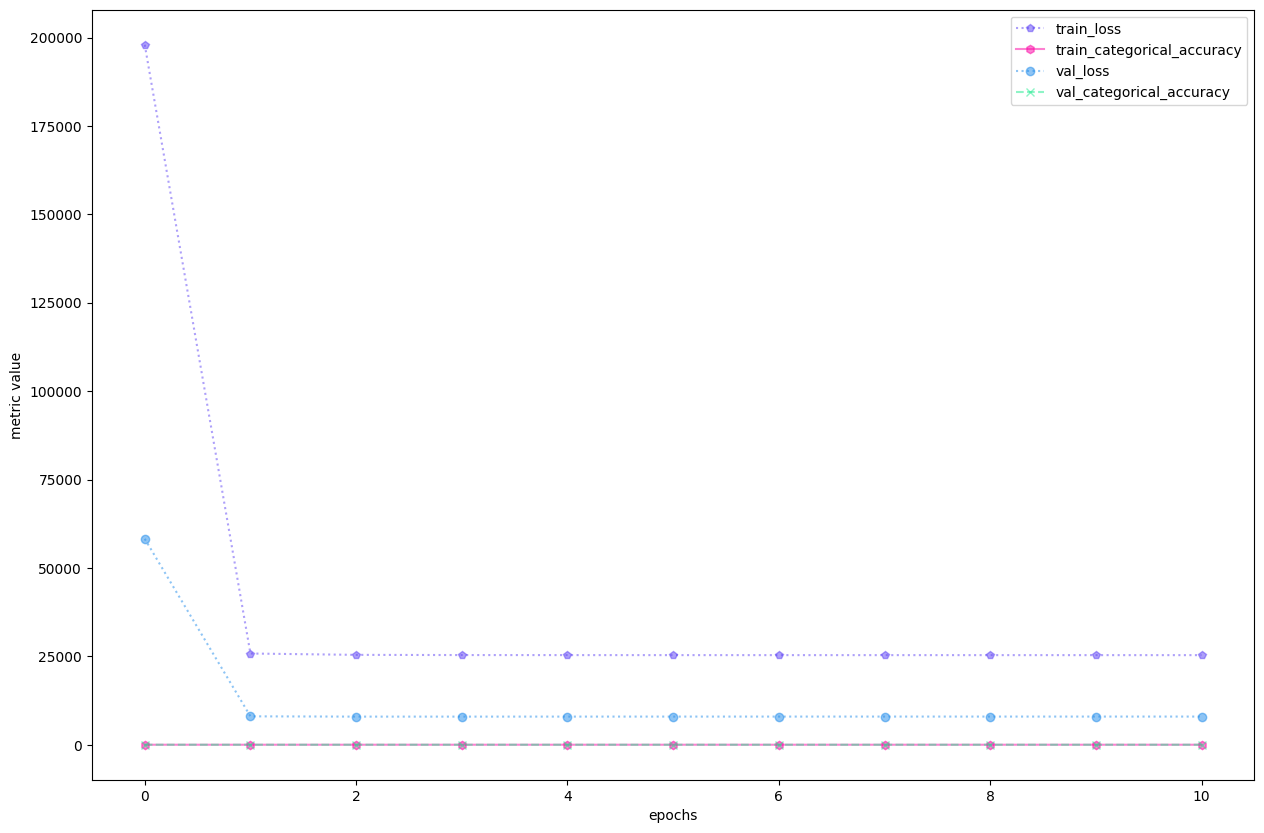

In [168]:
train_cross_results_v2(softmax_results, epochs=softmax_history['epoch'], img_title='softmax regression classifier results')

In [169]:
# display values from last epoch of baseline model
view_final_metrics(softmax_results, 'SOFTMAX REGRESSION CLASSIFIER RESULTS')


SOFTMAX REGRESSION CLASSIFIER RESULTS:
train_loss: 25335.998484820615
train_categorical_accuracy: 0.7918603135994441
val_loss: 7961.80044057149
val_categorical_accuracy: 0.782668500687758


In [170]:
# bug of accuracy precision recall and f1 score being all athe same: https://stackoverflow.com/questions/62792001/precision-and-recall-are-the-same-within-a-model
# Looking at the documentation for these scores, it appears like they should all come out the same when you are using 'micro'.

# They are all counting the fraction of times that you get the correct label.

# See the examples:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

# In fact in the last three they all give the same example and of course get the same score.
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
# https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/


# predict probabilities for test set
Y_pred = model.predict(test_seqs)
print(Y_pred[0])
print(test_labels[0])

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, Y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(test_labels, Y_pred, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_labels, Y_pred, average='macro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, Y_pred, average='macro')
print('F1 score: %f' % f1)

# matrix = confusion_matrix(test_labels, Y_pred)
# print(matrix)

tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
[0. 1. 0. 0.]
Accuracy: 0.778754
Precision: 0.778754
Recall: 0.783527
F1 score: 0.789113
